In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('ticks')
COLOR_PALETTE = 'Set1'
sns.set_palette(COLOR_PALETTE)

/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from matplotlib import rc
rc('animation', html='html5')
from matplotlib.animation import FuncAnimation

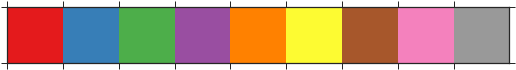

In [3]:
colors = sns.color_palette(COLOR_PALETTE, 9)
sns.palplot(colors)

red = colors[0]
blue = colors[1]
green = colors[2]
orange = colors[4]
gray = colors[8]

In [4]:
import string
random = np.random.RandomState(11116)
n_points = 30
data = random.randn(n_points, 2)

def random_word(length):
    letters = list(string.ascii_lowercase)
    letters_and_spaces = letters + [' ']
    
    if length < 3:
        label = ''.join(random.choice(letters, size=length))
    else:
        label = random.choice(letters)
        # allow spaces but not in first or last letter
        label += ''.join(random.choice(letters_and_spaces, size=length - 2))
        label += random.choice(letters)
        
    return label    

min_length = 5
max_length = 20 

labels = list(map(random_word, random.randint(min_length, max_length+1, size=n_points)))


In [5]:
from cleanlabels.cleanlabels import *

In [6]:
from matplotlib.collections import PatchCollection

def draw_bboxes(bboxes, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    patches = []
    for bbox in bboxes:
        patches.append(bbox.rectangle_patch(fill=True))
    
    patch_collection = PatchCollection(patches, **kwargs)
    
    ax.add_collection(patch_collection)
    
    
    

In [21]:
from cleanlabels.energy import energy_componentwise

def objective(bboxes, anchors, other_bboxes_qtree, axes_bbox, componentwise=False, **energy_kwargs):

    def f(state):
        new_bboxes = adjust_bboxes(state, bboxes, anchors)
        if not componentwise:
            total_energy = energy(new_bboxes, anchors, other_bboxes_qtree, axes_bbox, **energy_kwargs)
            return total_energy
        else:
            return energy_componentwise(new_bboxes, anchors, other_bboxes_qtree, axes_bbox)
        

    return f

from scipy.optimize import minimize

/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/networkx/drawing/layout.py:330: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pos==None:
100%|██████████| 30/30 [10:08<00:00, 21.83s/it]


BrokenPipeError: [Errno 32] Broken pipe

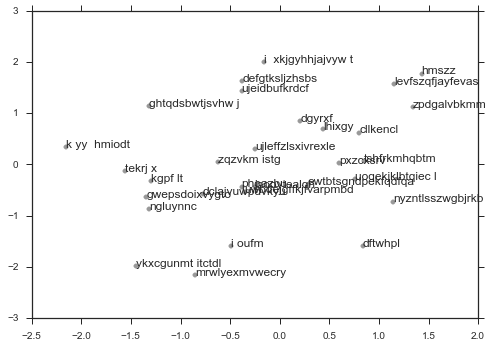

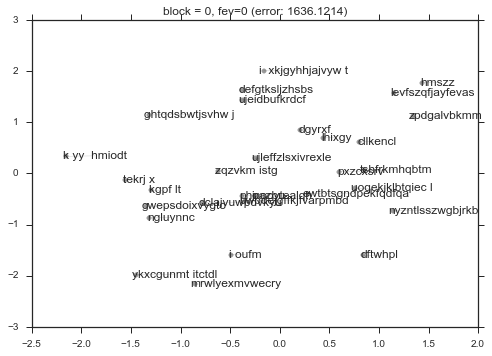

In [9]:
from tqdm import tqdm
anchor_x = data[:, 0]
anchor_y = data[:, 1]

spring_k = 1e-8
point_radius = 0.2

plt.figure()
ax = plt.gca()
ax.scatter(anchor_x, anchor_y, color=gray)



text_objects, anchors, label_bboxes, expansion_deltas, other_bboxes, other_bboxes_qtree = prepare(ax,
                                                                           anchor_x,
                                                                           anchor_y,
                                                                           labels,
                                                                           spring_k=spring_k,
                                                                           point_radius=point_radius)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

axes_bbox = Box(xlim[0], ylim[0], xlim[1], ylim[1])

states = [np.zeros(len(anchors)*2)]
n_blocks = 30
fev_in_block = int(len(anchors * 200) / n_blocks)

func = objective(label_bboxes, anchors, other_bboxes_qtree, axes_bbox, w_out_of_axes=40.0)

errors = [func(states[0])]

for block in tqdm(range(n_blocks)):
    initial_state = states[-1]
    
    ans = minimize(func, initial_state, 
                   method='powell',
                   options=dict(maxfev=fev_in_block))
    
    states.append(ans.x)
    errors.append(ans.fun)

    
def draw_labels(block, ax=None):
    if ax is None:
        ax = plt.gca()
    state = states[block]
    
    adjusted_texts = []
    
    adjusted_boxes = adjust_bboxes(state, label_bboxes, anchors)
    for text, box, expansion_delta in zip(text_objects,
                                          adjusted_boxes,
                                          expansion_deltas):
        
        box.translate(*expansion_delta)
        text = plt.text(box.x_min, box.y_min, text.get_text())
        text.set_position([box.x_min, box.y_min])
        adjusted_texts.append(text)
        
        

    annotation_kwargs = dict(arrowprops=dict(arrowstyle='-',
                                             shrinkA=0, shrinkB=0,
                                             connectionstyle="arc3",
                                             color='black',
                                             alpha=.3))
    
    texts_to_annotations(ax, adjusted_texts, anchors, **annotation_kwargs)
    plt.title('block = {}, fev={} (error: {:.4f})'.format(block, block*fev_in_block, errors[block]))

def draw_block(block):
    ax = plt.gca()
    ax.cla()
    
    ax.scatter(anchor_x, anchor_y, color=gray)
    draw_labels(block, ax=ax)

fig = plt.figure()
anim = FuncAnimation(fig, draw_block, 
                     frames=n_blocks+1, interval=200)
anim

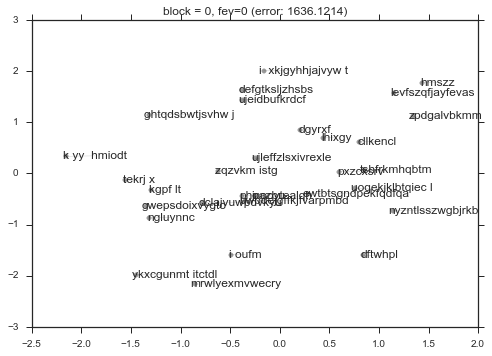

In [10]:
draw_block(0)

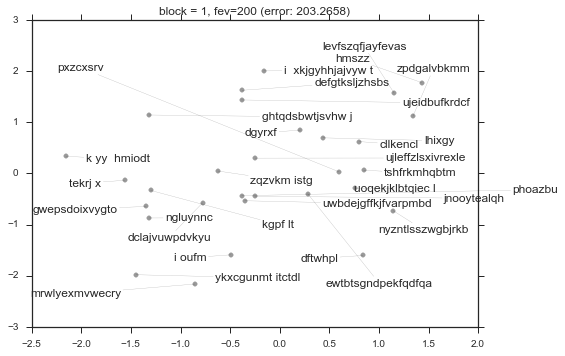

In [11]:
draw_block(1)

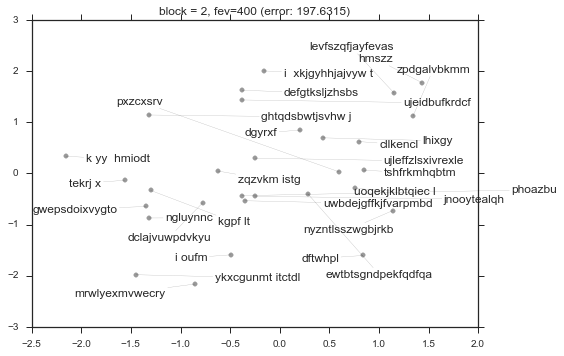

In [12]:
draw_block(2)

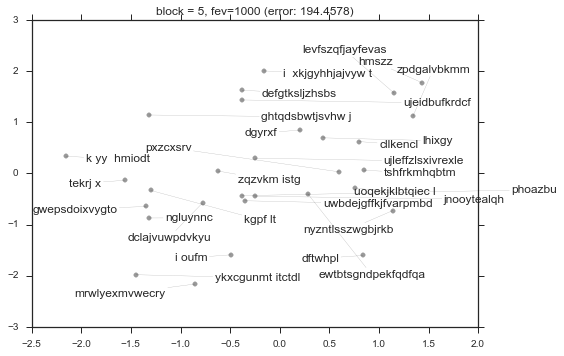

In [13]:
draw_block(5)

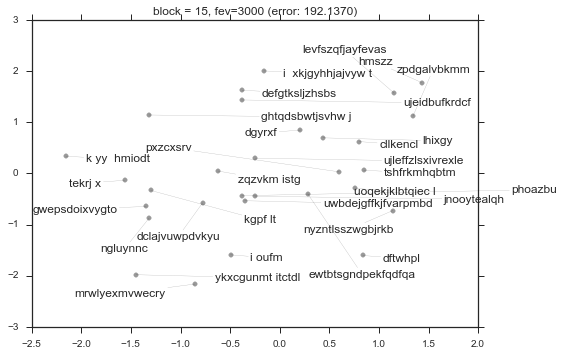

In [14]:
draw_block(15)

In [15]:
%timeit minimize(func, np.zeros(len(anchors) * 2), method='powell', options=dict(maxfev=1000))

1 loop, best of 3: 6.69 s per loop


In [18]:
from scipy.optimize import basinhopping

In [16]:
class TakeStep(object):
    
    
    def __init__(self, bboxes, anchors, axes_bbox):
        self.bboxes = bboxes
        self.anchors = anchors
        self.axes_bbox = axes_bbox
        
        
    def __call__(self, x):
        
        step_std = 0.25
        flip_prob = 0.2
        
        axes_bbox = self.axes_bbox
        
        x = x.reshape(-1, 2)
        
        i = np.random.choice(range(len(self.bboxes)))
        bbox = self.bboxes[i]
        anchor = self.anchors[i]
        
        current_pos = np.array([bbox.x_min, bbox.y_min])
        flip_x = np.random.choice([True, False], p=[flip_prob, 1-flip_prob])
        if flip_x:
            bbox = bbox.flip(anchor[0], axis=0)

        flip_y = np.random.choice([True, False], p=[flip_prob, 1-flip_prob])
        if flip_y:
            bbox = bbox.flip(anchor[1], axis=1)

        x_step = np.random.normal(loc=0.0, scale=step_std)
        y_step = np.random.normal(loc=0.0, scale=step_std)

        bbox = bbox.translate(x_step, y_step)
        
        correction_translation_x = 0
        correction_translation_y = 0
        
        if bbox.x_max > axes_bbox.x_max:
            correction_translation_x = axes_bbox.x_max - bbox.x_max
        elif bbox.x_min < axes_bbox.x_min:
            correction_translation_x = axes_bbox.x_min - bbox.x_min
        
        if bbox.y_max > axes_bbox.y_max:
            correction_translation_y = axes_bbox.y_max - bbox.y_max
        elif bbox.y_min < axes_bbox.y_min:
            correction_translation_y = axes_bbox.y_min - bbox.y_min
        
        if correction_translation_x != 0 and correction_translation_y != 0:
            bbox = bbox.translate(correction_translation_x, correction_translation_y)
        
        new_delta = np.array([bbox.x_min, bbox.y_min] - current_pos)

        x[i] = new_delta
        x = x.reshape(-1)
        
        return x
        
        

/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/networkx/drawing/layout.py:330: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pos==None:


basinhopping step 0: f 106.795
basinhopping step 1: f 25.4544 trial_f 25.4544 accepted 1  lowest_f 25.4544
found new global minimum on step 1 with function value 25.4544
basinhopping step 2: f 24.22 trial_f 24.22 accepted 1  lowest_f 24.22
found new global minimum on step 2 with function value 24.22
basinhopping step 3: f 24.2246 trial_f 24.2246 accepted 1  lowest_f 24.22
basinhopping step 4: f 21.7425 trial_f 21.7425 accepted 1  lowest_f 21.7425
found new global minimum on step 4 with function value 21.7425
basinhopping step 5: f 19.7789 trial_f 19.7789 accepted 1  lowest_f 19.7789
found new global minimum on step 5 with function value 19.7789
basinhopping step 6: f 19.7789 trial_f 26.8273 accepted 0  lowest_f 19.7789
basinhopping step 7: f 19.7789 trial_f 20.0766 accepted 0  lowest_f 19.7789
basinhopping step 8: f 20.1536 trial_f 20.1536 accepted 1  lowest_f 19.7789
basinhopping step 9: f 21.2057 trial_f 21.2057 accepted 1  lowest_f 19.7789
basinhopping step 10: f 21.2057 trial_f 25.

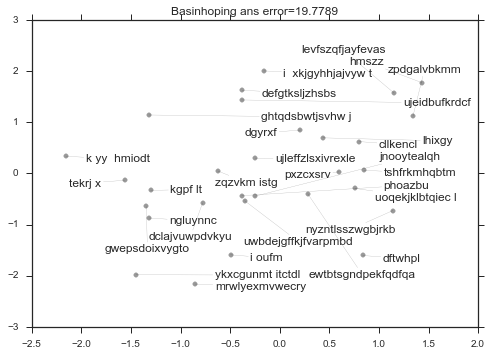

In [48]:
from tqdm import tqdm
anchor_x = data[:, 0]
anchor_y = data[:, 1]

spring_k = 1e-8
point_radius = 0.2

plt.figure()
ax = plt.gca()
ax.scatter(anchor_x, anchor_y, color=gray)



text_objects, anchors, label_bboxes, expansion_deltas, other_bboxes, other_bboxes_qtree = prepare(ax,
                                                                           anchor_x,
                                                                           anchor_y,
                                                                           labels,
                                                                           spring_k=spring_k,
                                                                           point_radius=point_radius)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

axes_bbox = Box(xlim[0], ylim[0], xlim[1], ylim[1])

x0 = np.zeros(len(anchors) * 2)

fev = 1000

func = objective(label_bboxes, anchors, other_bboxes_qtree, axes_bbox)
func_componentwise = objective(label_bboxes, anchors, other_bboxes_qtree, axes_bbox, componentwise=True)

ans = basinhopping(func, x0, 
                   niter=10,
                   T=1.0, 
                   minimizer_kwargs=dict(method='powell', options=dict(maxfev=fev)),
                   stepsize=0.5, 
                   take_step=TakeStep(label_bboxes, anchors, axes_bbox),
                   disp=True)

ax = plt.gca()
state = ans.x

adjusted_texts = []

adjusted_boxes = adjust_bboxes(state, label_bboxes, anchors)
for text, box, expansion_delta in zip(text_objects,
                                      adjusted_boxes,
                                      expansion_deltas):
    
    box.translate(*expansion_delta)
    text.set_visible(False)
    text = plt.text(box.x_min, box.y_min, text.get_text())
    text.set_position([box.x_min, box.y_min])
    adjusted_texts.append(text)


annotation_kwargs = dict(arrowprops=dict(arrowstyle='-',
                                         shrinkA=0, shrinkB=0,
                                         connectionstyle="arc3",
                                         color='black',
                                         alpha=.3))

texts_to_annotations(ax, adjusted_texts, anchors, **annotation_kwargs)
plt.title('Basinhoping ans error={:.4f}'.format(ans.fun))

In [20]:
from cleanlabels.energy import energy_componentwise

In [22]:
func_componentwise = objective(label_bboxes, anchors, other_bboxes_qtree, axes_bbox, componentwise=True)

In [23]:
func_componentwise(ans.x)

{'distances_to_anchor': 15.21234892576225,
 'n_intersecting_lines': 2,
 'n_overlaps': 0,
 'non_label_overlap_area': 0.0917577767048535,
 'orientation_penalties': 23,
 'out_of_axes_area': 0.0,
 'overlap_area': 0.0}

In [25]:
bboxes = adjust_bboxes(ans.x, label_bboxes, anchors)

In [32]:
import itertools
import pandas as pd
overlaps = []
for bbox_a, bbox_b in itertools.combinations(bboxes, 2):
    overlaps.append(bbox_a.overlap(bbox_b))
overlaps = pd.Series(overlaps)

In [34]:
overlaps.value_counts()

0.0    435
dtype: int64

In [31]:
energy_componentwise(bboxes, anchors, other_bboxes_qtree, axes_bbox)

{'distances_to_anchor': 15.21234892576225,
 'n_intersecting_lines': 2,
 'n_overlaps': 0,
 'non_label_overlap_area': 0.0917577767048535,
 'orientation_penalties': 23,
 'out_of_axes_area': 0.0,
 'overlap_area': 0.0}

In [37]:
[x.get_text() for x in text_objects].index('zpdgalvbkmm')

9

In [44]:
bboxes[9].area()

0.19076300728407899

In [43]:
bboxes[9].overlap(axes_bbox)

0.190763007284079

In [45]:
axes_bbox

Box(-2.5, -3.0, 2.0, 3.0)

In [46]:
bboxes[9]

Box(0.13247595670979773, 1.2792693726781978, 0.95381668251625, 1.5115274371943266)